In [1]:
from baseline_cnn import *
from baseline_cnn import BasicCNN
from cnn_model1 import Model1CNN
from cnn_model2 import Model2CNN

# Data utils and dataloader
import torchvision
from torchvision import transforms, utils
from xray_dataloader import ChestXrayDataset, create_split_loaders

import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
def accuracy(predictions, labels):
    return np.sum(predictions == labels) / float(labels.size)

In [3]:
def precision(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1))
    FP = np.sum(np.logical_and(predictions != labels, predictions == 1))
    return TP / float(FP + TP + 1)

In [4]:
def recall(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1))
    FN = np.sum(np.logical_and(predictions != labels, predictions == 0))
    return TP / float(FN + TP + 1)

In [5]:
def BCR(predictions, labels):
    return (precision(predictions, labels) + recall(predictions, labels)) / 2.0

In [6]:
def accuracy_per_class(predictions, labels):
    return np.sum(predictions == labels, axis=0) / float(labels.shape[0])

In [7]:
def precision_per_class(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1), axis=0)
    FP = np.sum(np.logical_and(predictions != labels, predictions == 1), axis=0)
    return TP / np.asfarray(FP + TP + 1)

In [8]:
def recall_per_class(predictions, labels):
    TP = np.sum(np.logical_and(predictions == labels, labels == 1), axis=0)
    FN = np.sum(np.logical_and(predictions != labels, predictions == 0), axis=0)
    return TP / np.asfarray(FN + TP + 1)

In [9]:
def BCR_per_class(predictions, labels):
    return (precision_per_class(predictions, labels) + recall_per_class(predictions, labels)) / 2.0

In [10]:
def confusion_matrix(mtx, predictions, actuals): 
    for p,a in zip(predictions, actuals):
        
        for i in range(p.shape[0]):
            # If TP, add 1 to diagonal
            # Then discard the other outputs
            if p[i] == 1 and a[i] == 1:
                mtx[i][i] += 1
                
            elif p[i] == 1:
                mtx[i] += a
    
    return mtx

In [11]:
def print_scores(batch_start, batch_count, accuracies, precisions, recalls, BCRs, aggregate=True):
    if aggregate:
        acc = np.mean(accuracies[batch_start:])
        pre = np.mean(precisions[batch_start:])
        rec = np.mean(recalls[batch_start:])
        bcr = np.mean(BCRs[batch_start:])
    else:
        acc = np.mean(accuracies[batch_start:], axis=0)
        pre = np.mean(precisions[batch_start:], axis=0)
        rec = np.mean(recalls[batch_start:], axis=0)
        bcr = np.mean(BCRs[batch_start:], axis=0)
            
    # Print the loss averaged over the last N mini-batches    
    print('Minibatch ' + str(batch_count) + ' accuracy: ' + str(acc))
    print('Minibatch ' + str(batch_count) + ' precision: ' + str(pre))
    print('Minibatch ' + str(batch_count) + ' recall: ' + str(rec))
    print('Minibatch ' + str(batch_count) + ' bcr: ' + str(bcr))

In [20]:
def train_model(model, model_name, num_epochs, train_loader, computing_device, optimizer, criterion):
    # Track the loss across training
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    
    start = time.time()
    
    # When to record results
    N_training_loss = len(train_loader) // 4
    N_minibatch_print = 50
    
    min_val_loss = 100    
    
    for epoch in range(num_epochs):
        
        # Training
        minibatch_loss_for_print = 0.0
        minibatch_loss_for_results = 0.0
        minibatch_acc_for_results = 0.0
        
        for minibatch_count, (images, labels) in enumerate(train_loader, 0):

            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)

            # Zero out the stored gradient (buffer) from the previous iteration
            optimizer.zero_grad()

            # Perform the forward pass through the network and compute the loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
            # if isinstance(criterion, nn.BCEWithLogitsLoss):
                # outputs = torch.sigmoid(outputs)
                
            predicted = torch.round(outputs.data)
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            acc = accuracy(predicted, labels)

            # Automagically compute the gradients and backpropagate the loss through the network
            loss.backward()

            # Update the weights
            optimizer.step()

            # Add this iteration's loss to the total minibatch loss
            minibatch_loss_for_print += loss
            minibatch_loss_for_results += loss
            minibatch_acc_for_results += acc
            
            # Save the training loss every quarter of the training data
            if (minibatch_count + 1) % N_training_loss == 0:
                train_loss.append(minibatch_loss_for_results / N_training_loss)
                minibatch_loss_for_results = 0.0
                train_accuracy.append(minibatch_acc_for_results / N_training_loss)
                minibatch_acc_for_results = 0.0

            # Print the training loss every N_minibatches
            if (minibatch_count + 1) % N_minibatch_print == 0:   
                print('Epoch %d, average minibatch %d loss: %.3f' %
                    (epoch + 1, minibatch_count, minibatch_loss_for_print / N_minibatch_print))
                print(100 * minibatch_count/len(train_loader),"% done, " ,time.time() - start, " Seconds elapsed")
                
                minibatch_loss_for_print = 0.0
                
            #if len(train_accuracy) >= 2:
                #break

                
        # Validation
        val_loss = 0.0
        val_acc = 0.0
        early_stop_count = 0 
        
        # When to record results
        N_valid_loss = len(val_loader) // 4
        
        with torch.no_grad():
            for batch_count, (images, labels) in enumerate(val_loader, 0):
                images, labels = images.to(computing_device), labels.to(computing_device)

                optimizer.zero_grad()

                outputs = model(images)
                val_loss += criterion(outputs, labels)
                
                # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
                # if type(criterion) == 'BCEWithLogitsLoss':
                    # outputs = torch.sigmoid(outputs)
                
                predicted = torch.round(outputs.data)
                predicted = predicted.cpu().numpy()
                labels = labels.cpu().numpy()
                val_acc += accuracy(predicted, labels)
                
                # Save the validation loss every quarter of the validation data
                if (batch_count + 1) % N_valid_loss == 0:
                    valid_loss.append(val_loss / N_valid_loss)
                    val_loss = 0.0
                    valid_accuracy.append(val_acc / N_valid_loss)
                    val_acc = 0.0
                

            # Early stopping
            '''  
            if val_loss >= min_loss:
                early_stop_count += 1
                if early_stop_count == 2:
                    break

            else:
                early_stop_count = 0
                min_loss = val_loss
            '''

        print('Saving model')
        torch.save(model, model_name + str(epoch) + '.pt')
        print("Finished", epoch + 1, "epochs of training")
        
    print("Training complete after", epoch + 1, "epochs")
    
    return train_loss, valid_loss, train_accuracy, valid_accuracy, time.time() - start

In [13]:
def test_model(model, test_loader, computing_device, optimizer, criterion):
    agg_accuracies = []
    agg_precisions = []
    agg_recalls = []
    agg_BCRs = []

    class_accuracies = []
    class_precisions = []
    class_recalls = []
    class_BCRs = []
    
    total_acc_per_class = [0] * 14
    total_pre_per_class = [0] * 14
    total_rec_per_class = [0] * 14
    total_BCR_per_class = [0] * 14
    
    conf_mtx = np.zeros((14, 14), dtype = np.float32)
    
    batch_start = 0
    N = 50

    with torch.no_grad():
        # Get the next minibatch of images, labels 
        for minibatch_count, (images, labels) in enumerate(test_loader, 0):
            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images, labels = images.to(computing_device), labels.to(computing_device)

            # Zero out the stored gradient (buffer) from the previous iteration
            #optimizer.zero_grad()

            # Perform the forward pass through the network and compute the loss
            outputs = model(images)
            
            # Performs sigmoid on the output for when the criterion is BCEWithLogitsLogs
            # if type(criterion) == 'BCEWithLogitsLoss':
                # outputs = torch.sigmoid(outputs)
            
            predicted = torch.round(outputs.data)

            # Convert from Cuda tensor -> numpy array
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()

            conf_mtx = confusion_matrix(conf_mtx, predicted, labels)

            # Compute aggregated scores
            acc = accuracy(predicted, labels)
            pre = precision(predicted, labels)
            rec = recall(predicted, labels)
            bcr = BCR(predicted, labels)

            agg_accuracies.append(acc)
            agg_precisions.append(pre)
            agg_recalls.append(rec)
            agg_BCRs.append(bcr)

            # Compute scores by class
            acc = accuracy_per_class(predicted, labels)
            pre = precision_per_class(predicted, labels)
            rec = recall_per_class(predicted, labels)
            bcr = BCR_per_class(predicted, labels)

            class_accuracies.append(acc)
            class_precisions.append(pre)
            class_recalls.append(rec)
            class_BCRs.append(bcr)
            
            total_acc_per_class += acc
            total_pre_per_class += pre
            total_rec_per_class += rec
            total_BCR_per_class += bcr

            if (minibatch_count + 1) % N == 0: 
                # Print the loss averaged over the last N mini-batches
                print('----- Aggregated Scores -----')
                print_scores(batch_start, minibatch_count, agg_accuracies, 
                             agg_precisions, agg_recalls, agg_BCRs, aggregate=True)
                '''
                print('----- Scores By Class -----')
                print_scores(batch_start, minibatch_count, class_accuracies, 
                             class_precisions, class_recalls, class_BCRs, aggregate=False)
                '''
                batch_start = minibatch_count + 1
                
            #if (minibatch_count + 1) % 200 == 0:
                #break
                
    return total_acc_per_class / minibatch_count, total_pre_per_class / minibatch_count, total_rec_per_class / minibatch_count, total_BCR_per_class / minibatch_count, conf_mtx 

In [14]:
# BASELINE

# model hyperparameters
num_epochs = 2           # Number of full passes through the dataset
batch_size = 16          # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.05              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


# other model parameters
transform = transforms.Compose(
    [transforms.Resize(512), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# trains the model
model = BasicCNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Baseline', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)

print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('----------------------}----------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j]) 
        
print(conf_mtx)



CUDA is supported
Model on CUDA? True
Epoch 1, average minibatch 49 loss: 0.258
0.9200150206533985 % done,  56.600831270217896  Seconds elapsed
Epoch 1, average minibatch 99 loss: 0.207
1.8588058580548255 % done,  112.76490378379822  Seconds elapsed
Epoch 1, average minibatch 149 loss: 0.204
2.7975966954562526 % done,  167.19235730171204  Seconds elapsed
Epoch 1, average minibatch 199 loss: 0.201
3.7363875328576794 % done,  222.0843803882599  Seconds elapsed
Epoch 1, average minibatch 249 loss: 0.194
4.675178370259106 % done,  277.1301259994507  Seconds elapsed
Epoch 1, average minibatch 299 loss: 0.189
5.613969207660533 % done,  331.27949476242065  Seconds elapsed
Epoch 1, average minibatch 349 loss: 0.187
6.5527600450619605 % done,  385.0614011287689  Seconds elapsed
Epoch 1, average minibatch 399 loss: 0.197
7.491550882463387 % done,  438.62282037734985  Seconds elapsed
Epoch 1, average minibatch 449 loss: 0.192
8.430341719864813 % done,  492.07686281204224  Seconds elapsed
Epoch 1,

Epoch 1, average minibatch 3899 loss: 0.183
73.20690950056327 % done,  4140.255754232407  Seconds elapsed
Epoch 1, average minibatch 3949 loss: 0.187
74.1457003379647 % done,  4192.986274957657  Seconds elapsed
Epoch 1, average minibatch 3999 loss: 0.174
75.08449117536613 % done,  4246.4630382061005  Seconds elapsed
Epoch 1, average minibatch 4049 loss: 0.177
76.02328201276755 % done,  4299.320706367493  Seconds elapsed
Epoch 1, average minibatch 4099 loss: 0.180
76.96207285016898 % done,  4352.09809923172  Seconds elapsed
Epoch 1, average minibatch 4149 loss: 0.178
77.9008636875704 % done,  4405.478303670883  Seconds elapsed
Epoch 1, average minibatch 4199 loss: 0.183
78.83965452497183 % done,  4458.63759803772  Seconds elapsed
Epoch 1, average minibatch 4249 loss: 0.180
79.77844536237326 % done,  4511.325334072113  Seconds elapsed
Epoch 1, average minibatch 4299 loss: 0.176
80.71723619977469 % done,  4564.636889696121  Seconds elapsed
Epoch 1, average minibatch 4349 loss: 0.180
81.65

Epoch 2, average minibatch 2449 loss: 0.184
45.98197521592189 % done,  8634.908341884613  Seconds elapsed
Epoch 2, average minibatch 2499 loss: 0.178
46.92076605332332 % done,  8688.673123121262  Seconds elapsed
Epoch 2, average minibatch 2549 loss: 0.173
47.85955689072475 % done,  8742.151139974594  Seconds elapsed
Epoch 2, average minibatch 2599 loss: 0.172
48.798347728126174 % done,  8795.697474479675  Seconds elapsed
Epoch 2, average minibatch 2649 loss: 0.172
49.7371385655276 % done,  8849.664703845978  Seconds elapsed
Epoch 2, average minibatch 2699 loss: 0.186
50.67592940292903 % done,  8903.058453798294  Seconds elapsed
Epoch 2, average minibatch 2749 loss: 0.170
51.614720240330456 % done,  8957.193876028061  Seconds elapsed
Epoch 2, average minibatch 2799 loss: 0.178
52.55351107773188 % done,  9010.980063676834  Seconds elapsed
Epoch 2, average minibatch 2849 loss: 0.186
53.49230191513331 % done,  9063.61995601654  Seconds elapsed
Epoch 2, average minibatch 2899 loss: 0.165
54

----- Aggregated Scores -----
Minibatch 749 accuracy: 0.9499107142857143
Minibatch 749 precision: 0.0
Minibatch 749 recall: 0.0
Minibatch 749 bcr: 0.0
----- Aggregated Scores -----
Minibatch 799 accuracy: 0.9461607142857145
Minibatch 799 precision: 0.0
Minibatch 799 recall: 0.0
Minibatch 799 bcr: 0.0
----- Aggregated Scores -----
Minibatch 849 accuracy: 0.9472321428571427
Minibatch 849 precision: 0.0
Minibatch 849 recall: 0.0
Minibatch 849 bcr: 0.0
----- Aggregated Scores -----
Minibatch 899 accuracy: 0.9530357142857143
Minibatch 899 precision: 0.0
Minibatch 899 recall: 0.0
Minibatch 899 bcr: 0.0
----- Aggregated Scores -----
Minibatch 949 accuracy: 0.9455357142857143
Minibatch 949 precision: 0.0
Minibatch 949 recall: 0.0
Minibatch 949 bcr: 0.0
----- Aggregated Scores -----
Minibatch 999 accuracy: 0.9458035714285713
Minibatch 999 precision: 0.0
Minibatch 999 recall: 0.0
Minibatch 999 bcr: 0.0
----- Aggregated Scores -----
Minibatch 1049 accuracy: 0.9487499999999999
Minibatch 1049 preci

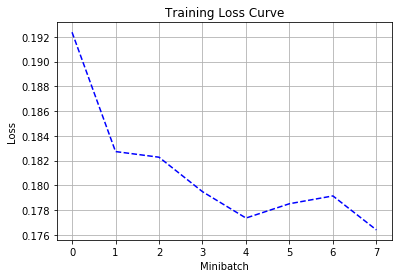

In [15]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'training loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("Baseline Model Loss Curve")
plt.legend(loc="upper right")

plt.savefig("images/m0_loss.png")

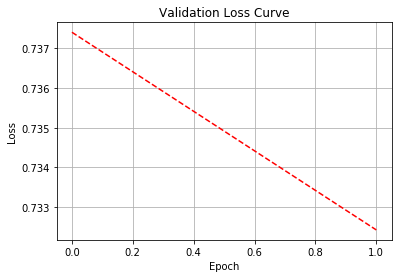

In [16]:
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curve")

plt.savefig("images/m0_v_loss.png")

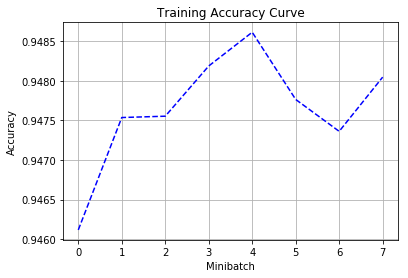

In [17]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'training accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("Baseline Model Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m0_acc.png")

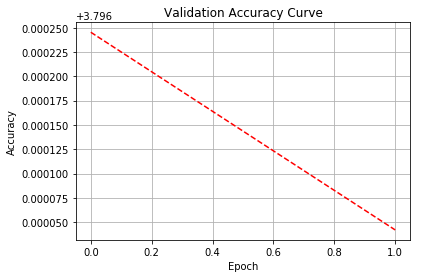

In [18]:
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")

plt.savefig("images/m0_v_acc.png")

In [21]:
# CUSTOM MODEL 1

# model architecture parameters
channel = [1, 8, 8, 8, 16, 16, 16, 32, 32, 32]
block_size = 3
kernel = [5]*9
pool_kernel = 2
pool_stride = 2

# model hyperparameters
num_epochs = 2           # Number of full passes through the dataset
batch_size = 16          # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.05              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


# other model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# Instantiate a BasicCNN to run on the GPU or CPU based on CUDA support
model = Model1CNN(256, channel, kernel, block_size, pool_kernel, pool_stride)
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Custom1', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)


print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)


print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('----------------------}----------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j]) 
        
print(conf_mtx)

CUDA is supported
Model on CUDA? True
Epoch 1, average minibatch 49 loss: 0.251
0.9200150206533985 % done,  55.41750478744507  Seconds elapsed
Epoch 1, average minibatch 99 loss: 0.207
1.8588058580548255 % done,  110.98555994033813  Seconds elapsed
Epoch 1, average minibatch 149 loss: 0.181
2.7975966954562526 % done,  166.61180210113525  Seconds elapsed
Epoch 1, average minibatch 199 loss: 0.185
3.7363875328576794 % done,  221.82344913482666  Seconds elapsed
Epoch 1, average minibatch 249 loss: 0.190
4.675178370259106 % done,  275.8945643901825  Seconds elapsed
Epoch 1, average minibatch 299 loss: 0.182
5.613969207660533 % done,  333.9826464653015  Seconds elapsed
Epoch 1, average minibatch 349 loss: 0.187
6.5527600450619605 % done,  389.65243196487427  Seconds elapsed
Epoch 1, average minibatch 399 loss: 0.184
7.491550882463387 % done,  443.26309871673584  Seconds elapsed
Epoch 1, average minibatch 449 loss: 0.187
8.430341719864813 % done,  497.7122654914856  Seconds elapsed
Epoch 1, 

Epoch 1, average minibatch 3899 loss: 0.176
73.20690950056327 % done,  4210.477823495865  Seconds elapsed
Epoch 1, average minibatch 3949 loss: 0.173
74.1457003379647 % done,  4264.034380912781  Seconds elapsed
Epoch 1, average minibatch 3999 loss: 0.173
75.08449117536613 % done,  4318.177981138229  Seconds elapsed
Epoch 1, average minibatch 4049 loss: 0.164
76.02328201276755 % done,  4372.420008420944  Seconds elapsed
Epoch 1, average minibatch 4099 loss: 0.166
76.96207285016898 % done,  4426.625674247742  Seconds elapsed
Epoch 1, average minibatch 4149 loss: 0.172
77.9008636875704 % done,  4481.324751853943  Seconds elapsed
Epoch 1, average minibatch 4199 loss: 0.168
78.83965452497183 % done,  4534.636847496033  Seconds elapsed
Epoch 1, average minibatch 4249 loss: 0.175
79.77844536237326 % done,  4588.895458698273  Seconds elapsed
Epoch 1, average minibatch 4299 loss: 0.166
80.71723619977469 % done,  4643.084667444229  Seconds elapsed
Epoch 1, average minibatch 4349 loss: 0.173
81.6

Epoch 2, average minibatch 2449 loss: 0.171
45.98197521592189 % done,  8811.08956027031  Seconds elapsed
Epoch 2, average minibatch 2499 loss: 0.164
46.92076605332332 % done,  8865.627037763596  Seconds elapsed
Epoch 2, average minibatch 2549 loss: 0.158
47.85955689072475 % done,  8920.902185201645  Seconds elapsed
Epoch 2, average minibatch 2599 loss: 0.179
48.798347728126174 % done,  8975.935278892517  Seconds elapsed
Epoch 2, average minibatch 2649 loss: 0.166
49.7371385655276 % done,  9030.800875663757  Seconds elapsed
Epoch 2, average minibatch 2699 loss: 0.169
50.67592940292903 % done,  9084.804098367691  Seconds elapsed
Epoch 2, average minibatch 2749 loss: 0.164
51.614720240330456 % done,  9139.822118282318  Seconds elapsed
Epoch 2, average minibatch 2799 loss: 0.170
52.55351107773188 % done,  9195.689925432205  Seconds elapsed
Epoch 2, average minibatch 2849 loss: 0.165
53.49230191513331 % done,  9251.368615865707  Seconds elapsed
Epoch 2, average minibatch 2899 loss: 0.157
54

----- Aggregated Scores -----
Minibatch 599 accuracy: 0.9500892857142859
Minibatch 599 precision: 0.03
Minibatch 599 recall: 0.004299384825700615
Minibatch 599 bcr: 0.017149692412850307
----- Aggregated Scores -----
Minibatch 649 accuracy: 0.9476785714285715
Minibatch 649 precision: 0.04333333333333333
Minibatch 649 recall: 0.008531246531246532
Minibatch 649 bcr: 0.02593228993228993
----- Aggregated Scores -----
Minibatch 699 accuracy: 0.9449107142857143
Minibatch 699 precision: 0.065
Minibatch 699 recall: 0.011068467480232184
Minibatch 699 bcr: 0.038034233740116094
----- Aggregated Scores -----
Minibatch 749 accuracy: 0.9500892857142857
Minibatch 749 precision: 0.07
Minibatch 749 recall: 0.01246897546897547
Minibatch 749 bcr: 0.041234487734487735
----- Aggregated Scores -----
Minibatch 799 accuracy: 0.9499107142857143
Minibatch 799 precision: 0.06333333333333332
Minibatch 799 recall: 0.014841269841269843
Minibatch 799 bcr: 0.03908730158730158
----- Aggregated Scores -----
Minibatch 84

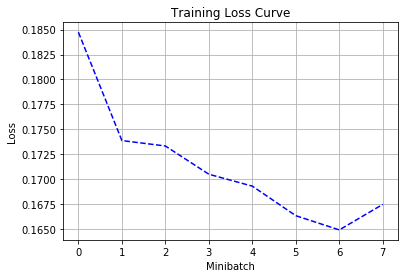

In [22]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'training loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("Customized Model Loss Curve")
plt.legend(loc="upper right")

plt.savefig("images/m1_loss.png")

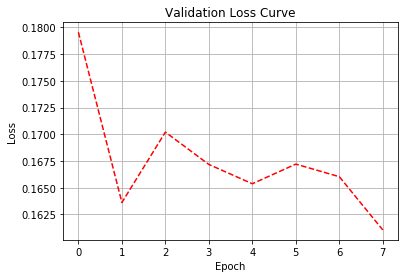

In [23]:
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curve")

plt.savefig("images/m1_v_loss.png")

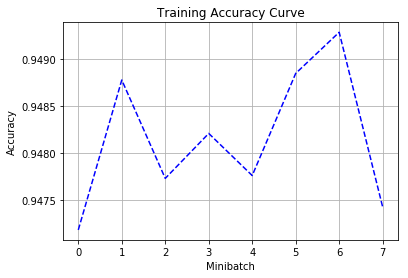

In [24]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'training accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("Customized Model Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m1_acc.png")

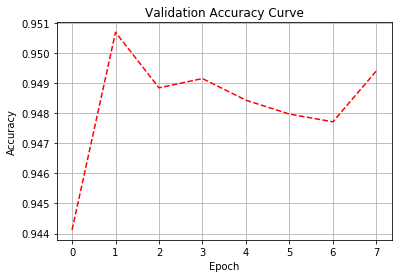

In [ ]:
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")

plt.savefig("images/m1_v_acc.png")

In [ ]:
# CUSTOM MODEL 2

# model hyperparameters
num_epochs = 2           # Number of full passes through the dataset
batch_size = 16          # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.05             # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


# other model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# trains the model
model = Model2CNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCELoss()

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Custom2', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)

print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('----------------------}----------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j]) 
        
print(conf_mtx)



CUDA is supported
Model on CUDA? True
Epoch 1, average minibatch 49 loss: 0.217
0.9200150206533985 % done,  57.077985763549805  Seconds elapsed
Epoch 1, average minibatch 99 loss: 0.179
1.8588058580548255 % done,  114.06129026412964  Seconds elapsed
Epoch 1, average minibatch 149 loss: 0.183
2.7975966954562526 % done,  170.6911609172821  Seconds elapsed
Epoch 1, average minibatch 199 loss: 0.185
3.7363875328576794 % done,  227.85927319526672  Seconds elapsed
Epoch 1, average minibatch 249 loss: 0.178
4.675178370259106 % done,  285.18145418167114  Seconds elapsed
Epoch 1, average minibatch 299 loss: 0.188
5.613969207660533 % done,  343.1656000614166  Seconds elapsed
Epoch 1, average minibatch 349 loss: 0.185
6.5527600450619605 % done,  400.4070746898651  Seconds elapsed
Epoch 1, average minibatch 399 loss: 0.178
7.491550882463387 % done,  457.88527822494507  Seconds elapsed
Epoch 1, average minibatch 449 loss: 0.188
8.430341719864813 % done,  515.3572218418121  Seconds elapsed
Epoch 1, 

In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'training loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("ResNet12 Loss Curve")
plt.legend(loc='upper right')

plt.savefig("images/m2_loss.png")

In [ ]:
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curve")

plt.savefig("images/m2_v_loss.png")

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'training accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("ResNet12 Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m2_acc.png")

In [ ]:
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")

plt.savefig("images/m2_v_acc.png")

In [ ]:
weights = model.conv1.weight.data.cpu().numpy()
plt.imshow(weights[0, 0])

plt.imsave('images/m2_early1.png', weights[0, 0])

In [ ]:
# Loads the model
model = torch.load('file_name')

In [ ]:
# Creates the weights to address the class imbalance
total_data_points = 0
total_class_counts = np.zeros((14, 1)).astype(np.float32)

for (images, labels) in train_loader:
    total_data_points += labels.shape[0]
    total_class_counts += np.sum(labels, axis=0)
    
inverse_class_frequency = total_data_points / (total_data_points - total_class_counts)

In [ ]:
# RERUN CUSTOM MODEL 2 WITH CLASS BALANCING
# TODO: remove 

# model hyperparameters
num_epochs = 2           # Number of full passes through the dataset
batch_size = 16          # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.05             # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


# other model parameters
transform = transforms.Compose(
    [transforms.Resize(256), 
     transforms.ToTensor()])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

# trains the model
model = Model2CNN()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

# Define the loss criterion and instantiate the gradient descent optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=inverse_class_frequency)

# Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss, valid_loss, train_acc, valid_acc, time_elapsed = train_model(model, 'Custom2ClassBalance', num_epochs, train_loader, computing_device, optimizer, criterion)
class_acc, class_pre, class_rec, class_bcr, conf_mtx = test_model(model, test_loader, computing_device, optimizer, criterion)


print('--------------------------------------------------------------------------')
print("Training loss")
print(train_loss)

print('--------------------------------------------------------------------------')
print("Validation loss")
print(valid_loss)

print('--------------------------------------------------------------------------')
print("Training accuracy")
print(train_acc)

print('--------------------------------------------------------------------------')
print("Validation accuracy")
print(valid_acc)

print('--------------------------------------------------------------------------')
print("Per class accuracy")
print(class_acc)

print('----------------------}----------------------------------------------------')
print("Per class precision")
print(class_pre)

print('--------------------------------------------------------------------------')
print("Per class recall")
print(class_rec)

print('--------------------------------------------------------------------------')
print("Per class BCR")
print(class_bcr)

print('--------------------------------------------------------------------------')
print("Confusion matrix")
for j in range(conf_mtx.shape[0]):
    if np.sum(conf_mtx[j]) != 0:
        conf_mtx[j] /= np.sum(conf_mtx[j]) 
        
print(conf_mtx)



In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'training loss')
plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'validation loss')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.title("ResNet12 Loss Curve")
plt.legend(loc='upper right')

plt.savefig("images/m3_loss.png")

In [ ]:
plt.plot(range(len(train_acc)), train_acc, 'b--', label = 'training accuracy')
plt.plot(range(len(valid_acc)), valid_acc, 'r--', label = 'validation accuracy')

plt.grid(True)

plt.xlabel("Minibatch")
plt.ylabel("Accuracy")
plt.title("ResNet12 Accuracy Curve")
plt.legend(loc='lower right')

plt.savefig("images/m3_acc.png")